<a href="https://colab.research.google.com/github/sayyed-uoft/fullstackai/blob/main/13_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strata.ai - Artificial Intelligence Certificate 

# Module 3: Practical Deep Learning

# Training Deep Neural Networks
**Text Book:** Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, Second Edition, Aurélien Géron

Source: https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training Deep Neural Networks

So far, we used and trained very shallow neureal networks with just a few hidden layers. However, sometime we need to tackle a very complex problem, such as detecting hundreds of types of objects in high-resolution images. Consequently, we may need to train a much deeper DNN, perhaps with 10 layers or much more, each containing hundreds of neurons, connected by hundreds of thousands of connections. This would not be easy and you will face some challenges that we will discuss in this section.

# Vanishing/Exploding Gradients Problem

As discussed before, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step. When the number of layers is high, one of the following challenges may occur:

- **Vanising Gradients**: gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution.
- **Exploding Gradients**: the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges.



The researchers has found that the problem is the  combination of teh activation function and weight initialization methods. For example, one <a href="http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf" targetr="_blank">paper</a> showed that with the sigmoid activation function and random initialization of the wights using a standard normal distribution, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. Let's look at the sigmoid activation function:

In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


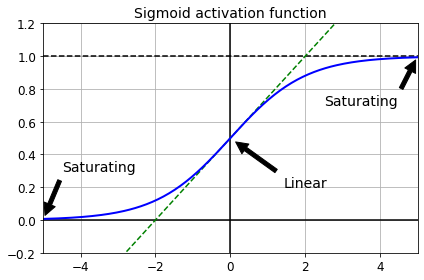

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Initialization Methods

The previously mwntioned paper suggested a new initialization method called **Glorot** (that last name of the paper's author) for the sigmoid function.

Other researchers suggested other initilization methods for other activation functions. Below is the best initialization methods for each activation function:

|Initialization|Activation Functions| 
|-----|-------| 
|Glorot|None, Tanh, Logistic, Softmax| 
|He|ReLU & variants|
|LeCun|SELU|

Here is the list of initialization methods supported by Keras:

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

By default, Keras uses Glorot initialization with a uniform distribution. You can change this to He initialization by setting kernel_initializer="he_uniform" or ker nel_initializer="he_normal" when creating a layer, like this:

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

## Nonsaturating Activation Functions

So far we learned that ReLU activation function works well for the hidden layer of the deep neural networks. However, the ReLU activation function is not perfect. It suffers from a problem known as the **dying ReLUs**: during training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neu‐ ron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting 0s, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.

One way to solve the above problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**.

$$LeakyReLU_\alpha(z) = max(\alpha z, z)$$

The hyperparameter $\alpha$ defines how much the function “leaks”. It is shown $\alpha = 0.2$ is a good value most of the times.

### Leaky ReLU

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


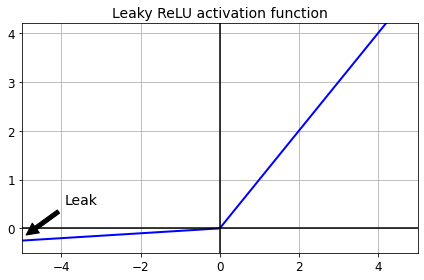

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Let's look at activation functions supported by Keras:

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Let's looka ad ReLU layers in Keras:

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

There are other variations. How do we select which one to use?

To use the leaky ReLU activation function, you must create a LeakyReLU instance like this:

In [ ]:
leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
layer = keras.layers.Dense(10, activation=leaky_relu,
kernel_initializer="he_normal")

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5339 - accuracy: 0.8223 - val_loss: 0.5156 - val_accuracy:

Now let's try Parametric leaky ReLU (PReLU), where $\alpha$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter):

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

### ELU

Another <a href="https://arxiv.org/abs/1511.07289" target="_blank">paper</a> has proposed a new activation function called **the exponential linear unit (ELU)** that outperformed all the ReLU variants in their experiments: training time was reduced and the neural network performed better on the test set.

$$ELU_\alpha(z) = \left\{\begin{matrix} \alpha(exp(z)-1) & z \lt 0\\ z & z \ge 0 \end{matrix}\right.$$

The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its variants (due to the use of the exponential function), but during training this is compensated by the faster convergence rate. However, at test time an ELU network will be slower than a ReLU network.

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


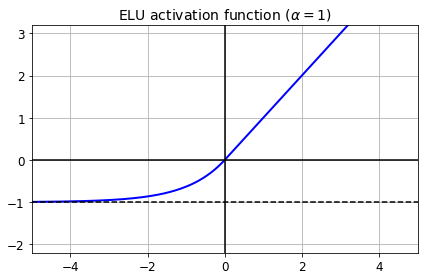

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


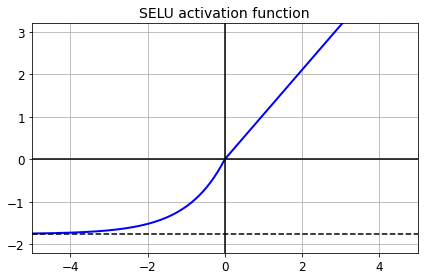

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [6]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 17ms/step - loss: 1.3776 - accuracy: 0.4540 - val_loss: 1.1731 - val_accuracy: 0.5614
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.9138 - accuracy: 0.6665 - val_loss: 0.7028 - val_accuracy: 0.7484
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6962 - accuracy: 0.7481 - val_loss: 0.6540 - val_accuracy: 0.7546
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6539 - accuracy: 0.7676 - val_loss: 0.5557 - val_accuracy: 0.7978
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.5582 - accuracy: 0.7990 - val_loss: 0.5703 - val_accuracy: 0.8016


Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 1.8261 - accuracy: 0.2616 - val_loss: 1.3347 - val_accuracy: 0.3894
Epoch 2/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1959 - accuracy: 0.4908 - val_loss: 0.9373 - val_accuracy: 0.5902
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.9600 - accuracy: 0.6118 - val_loss: 0.9026 - val_accuracy: 0.5906
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8231 - accuracy: 0.6759 - val_loss: 0.7320 - val_accuracy: 0.7290
Epoch 5/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.7360 - accuracy: 0.7171 - val_loss: 0.7823 - val_accuracy: 0.7108


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of train‐ ing, it doesn’t guarantee that they won’t come back during training.

Another [paper](https://arxiv.org/abs/1502.03167) has proposed a technique called **Batch Normalization (BN)** to address the vanishing/exploding gradients problems.

The technique consists of adding an operation in the model just before or after the activation function of each hidden layer, simply zero-centering and normalizing each input, then scaling and shifting the result using two new parameter vectors per layer for: 
1. scaling, 
1. shifting. 

This operation lets the model learn the optimal scale and mean of each of the layer’s inputs. 

In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler): the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and stan‐ dard deviation of each input over the current mini-batch (hence the name “Batch Normalization”).

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. So if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization perform before playing with Batch Normalization.

It is demonstrated that this technique considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes and commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturat‐ ing activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. They were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that “Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. 

As with most things with Keras, implementing Batch Normalization is quite simple. Just add a BatchNormalization layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8323 - accuracy: 0.7206 - val_loss: 0.5551 - val_accuracy: 0.8144
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5697 - accuracy: 0.8037 - val_loss: 0.4796 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5091 - accuracy: 0.8224 - val_loss: 0.4434 - val_accuracy: 0.8504
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4810 - accuracy: 0.8308 - val_loss: 0.4241 - val_accuracy: 0.8552
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4548 - accuracy: 0.8406 - val_loss: 0.4095 - val_accuracy: 0.8602
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4383 - accuracy: 0.8462 - val_loss: 0.3966 - val_accuracy: 0.8640
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4253 - accuracy: 0.8495 - val_loss: 0.3866 - val_accuracy

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 1.0820 - accuracy: 0.6659 - val_loss: 0.6781 - val_accuracy: 0.7940
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6758 - accuracy: 0.7849 - val_loss: 0.5505 - val_accuracy: 0.8230
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5877 - accuracy: 0.8071 - val_loss: 0.4948 - val_accuracy: 0.8380
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5410 - accuracy: 0.8189 - val_loss: 0.4619 - val_accuracy: 0.8468
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5113 - accuracy: 0.8278 - val_loss: 0.4403 - val_accuracy: 0.8530
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4860 - accuracy: 0.8362 - val_loss: 0.4242 - val_accuracy: 0.8560
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4710 - accuracy: 0.8385 - val_loss: 0.4108 - val_accuracy:

## Gradient Clipping

Another popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs. For other types of networks, BN is usually sufficient.

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

This will clip every component of the gradient vector to a value between –1.0 and 1.0.

If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue.

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called **transfer learning**. It will not only speed up training considerably, but will also require much less training data.

A common example is using pre-trained ImageNet models. 

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/transfer_learning.png" width="80%"/>

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.


### Reusing a Keras model

Let’s look at an example. Suppose the fashion MNIST dataset only contained 8 classes, for example all classes except for sandals and shirts. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirts, negative=san‐ dals). However, your dataset is quite small, you only have 200 labeled images. When you train a new model for this task (let’s call it model B), with the same architecture as model A, it performs reasonably well (97.2% accuracy), but since it’s a much easier task (there are just 2 classes), you were hoping for more.

This can be done with Transfer Learning.

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(43986, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2776 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy:

In [ ]:
model_A.save("my_model_A.h5")

Let's train the model B from scratch (same architecture):

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 37ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [ ]:
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

Now, let's use transfer learning.

First, you need to load model A, and create a new model based on the model A’s layers. Let’s reuse all layers except for the output layer:

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that model_A and model_B_on_A now share some layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you must clone model A’s architecture, then copy its weights (since clone_model() does not clone the weights):

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now we could just train model_B_on_A for task B, but since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, simply set every layer’s train able attribute to False and compile the model.

Next, we can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 38ms/step - loss: 0.5728 - accuracy: 0.6550 - val_loss: 0.5777 - val_accuracy: 0.6389
Epoch 2/4
7/7 [==============================] - 0s 15ms/step - loss: 0.5370 - accuracy: 0.6850 - val_loss: 0.5409 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 14ms/step - loss: 0.5008 - accuracy: 0.7300 - val_loss: 0.5094 - val_accuracy: 0.7130
Epoch 4/4
7/7 [==============================] - 0s 12ms/step - loss: 0.4699 - accuracy: 0.7500 - val_loss: 0.4812 - val_accuracy: 0.7343


In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 39ms/step - loss: 0.3926 - accuracy: 0.8200 - val_loss: 0.3436 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.2780 - accuracy: 0.9350 - val_loss: 0.2591 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2073 - accuracy: 0.9650 - val_loss: 0.2103 - val_accuracy: 0.9554
Epoch 4/16
7/7 [==============================] - 0s 13ms/step - loss: 0.1664 - accuracy: 0.9800 - val_loss: 0.1787 - val_accuracy: 0.9686
Epoch 5/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1394 - accuracy: 0.9800 - val_loss: 0.1559 - val_accuracy: 0.9767
Epoch 6/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1196 - accuracy: 0.9950 - val_loss: 0.1392 - val_accuracy: 0.9797
Epoch 7/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1050 - accuracy: 0.9950 - val_loss: 0.1266 - val_accuracy: 0.9838
Epoch 8/16
7/7 [===========

So, what's the final verdict?

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06824079155921936, 0.9929999709129333]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.5!

In [ ]:
(100 - 97.05) / (100 - 99.35)

4.538461538461503

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): 
1. applying a good initialization strategy for the connection weights
1. using a good activation function
1. using Batch Normalization
1. reusing parts of a pretrained network 

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.

## Momentum optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind **Momentum optimization**.

$$m= \beta m − \eta\triangledown_\theta J(\theta)$$
$$\theta = \theta + m$$
As you can see above, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, simply called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

What do you think is the disadvantage of momentum optimization?

## Nesterov Accelerated Gradient

The idea of **Nesterov Momentum optimization**, or **Nesterov Accelerated Gradient (NAG)**, is to measure the gradient of the cost function not at the local position but slightly ahead in the direc‐ tion of the momentum. It is a small variant to Momentum optimization, that is almost always faster than vanilla Momentum optimization. 


$$m= \beta m − \eta\triangledown_\theta J(\theta + \beta m)$$
$$\theta = \theta + m$$

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/nestrov.png" width="70%"/>

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

AdaGrad algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an **adaptive learning rate**. It helps point the resulting updates more directly toward the global optimum. One additional benefit is that it requires much less tuning of the learning rate hyperparameter.

AdaGrad often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though). However, understanding Adagrad is helpful to grasp the other adaptive learning rate optimizers.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/adagrad.png" width="70%"/>

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the begin‐ ning of training).

It introduces a new hyperparameter called **decay rate** ($\beta$) that is typically set to 0.9. Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

Adam, which stands for adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.

It introduces two new hyperparameters: 
- The momentum decay hyperparameter $\beta_1$ that is typically initialized to 0.9
- The scaling decay hyperparameter $\beta_2$ that is often initialized to 0.999

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter. You can often use the default value $\eta = 0.001$, making Adam even easier to use than Gradient Descent.


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

There are two variants of Adam that are worth mentioning:

1. Adamax
1. Nadam

## Adamax Optimization

In practice, Adamax can be more stable than Adam, but this really depends on the dataset, and in general Adam actually performs better. So it’s just one more optimizer you can try if you experience problems with Adam on some task.

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

Nadam is more important: it is simply Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In his report, Timothy Dozat compares many different optimizers on various tasks, and finds that Nadam generally outperforms Adam, but is sometimes outperformed by RMSProp.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Note

Adaptive optimization methods (including RMSProp, Adam and Nadam optimization) are often great, converging fast to a good solution. However, it is shown that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead.

## Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/learning_rate.png" width="70%"/>

You can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called **learning schedules**.

### Power Scheduling

Set the learning rate to a function of the iteration number $t$:

$$\eta(t) = \frac{\eta_0}{(1+t/s)^c}$$

The initial learning rate $\eta_0$, the power $c$ (typically set to 1) and the steps $s$ are hyperparameters. The learning rate drops at each step, and after $s$ steps it is down to $\eta_0 / 2$. After s more steps, it is down to $\eta_0 / 3$. Then down to $\eta_0 / 4$, then $\eta_0 / 5$, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, this requires tuning $\eta_0$, $s$ (and possibly $c$).

Keras uses $c = 1$ and $s = 1 / decay$.


In [3]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [7]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4883 - accuracy: 0.8274 - val_loss: 0.4144 - val_accuracy: 0.8556
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3813 - accuracy: 0.8652 - val_loss: 0.3773 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3478 - accuracy: 0.8761 - val_loss: 0.3611 - val_accuracy: 0.8756
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3269 - accuracy: 0.8839 - val_loss: 0.3521 - val_accuracy: 0.8768
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3104 - accuracy: 0.8902 - val_loss: 0.3509 - val_accuracy: 0.8734
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2979 - accuracy: 0.8947 - val_loss: 0.3419 - val_accuracy: 0.8798
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2878 - accuracy: 0.8973 - val_loss: 0.3372 - val_accuracy:

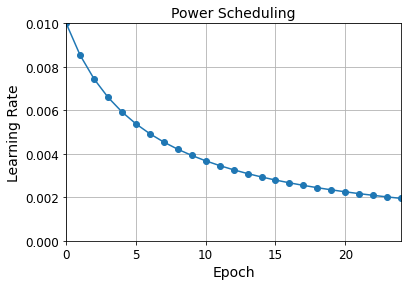

In [9]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

Set the learning rate to: $\eta(t) = \eta_0 0.1^{t/s}$. The learning rate will gradually drop by a factor of 10 every $s$ steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every $s$ steps.

In [10]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [11]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [13]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8630 - accuracy: 0.7581 - val_loss: 0.7837 - val_accuracy: 0.7840
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7095 - accuracy: 0.7881 - val_loss: 0.7008 - val_accuracy: 0.7968
Epoch 3/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7122 - accuracy: 0.7878 - val_loss: 0.6751 - val_accuracy: 0.8162
Epoch 4/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5943 - accuracy: 0.8224 - val_loss: 0.6913 - val_accuracy: 0.8278
Epoch 5/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5431 - accuracy: 0.8399 - val_loss: 0.6156 - val_accuracy: 0.8378
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4977 - accuracy: 0.8518 - val_loss: 0.5270 - val_accuracy: 0.8536
Epoch 7/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4593 - accuracy: 0.8623 - val_loss: 0.4771 - val_ac

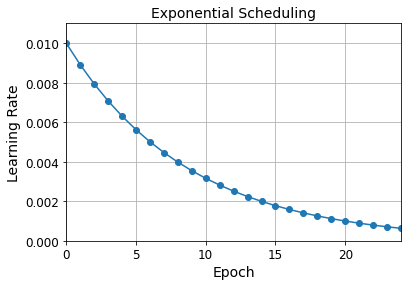

In [14]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [15]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [16]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.8669 - accuracy: 0.7492 - val_loss: 0.6698 - val_accuracy: 0.8066
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6330 - accuracy: 0.8034 - val_loss: 0.5857 - val_accuracy: 0.8212
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5549 - accuracy: 0.8282 - val_loss: 0.6318 - val_accuracy: 0.8120
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5046 - accuracy: 0.8417 - val_loss: 0.4538 - val_accuracy: 0.8648
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4610 - accuracy: 0.8527 - val_loss: 0.4823 - val_accuracy: 0.8526
Epoch 6/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4375 - accuracy: 0.8588 - val_loss: 0.4561 - val_accuracy: 0.8538
Epoch 7/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3830 - accuracy: 0.8737 - val_loss: 0.4830 - val_ac

In [18]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

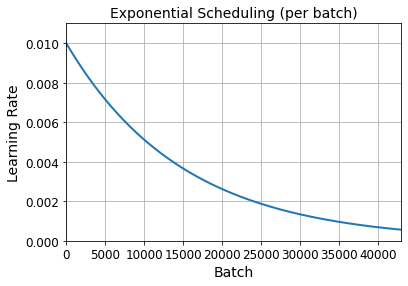

In [19]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

Use a constant learning rate for a number of epochs (e.g., $\eta_0 = 0.1$ for 5 epochs), then a smaller learning rate for another number of epochs (e.g., $\eta_1 = 0.001$ for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates, and how long to use each of them.

In [23]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [24]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

 Just create a LearningRateScheduler callback, giving it the schedule function, and pass this callback to the fit() method:

In [25]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8427 - accuracy: 0.7595 - val_loss: 0.6700 - val_accuracy: 0.8122
Epoch 2/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7676 - accuracy: 0.7741 - val_loss: 0.8139 - val_accuracy: 0.7682
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9203 - accuracy: 0.7321 - val_loss: 0.8723 - val_accuracy: 0.7300
Epoch 4/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8885 - accuracy: 0.7301 - val_loss: 0.8473 - val_accuracy: 0.7108
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8775 - accuracy: 0.7395 - val_loss: 1.1318 - val_accuracy: 0.6818
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6398 - accuracy: 0.8091 - val_loss: 0.8083 - val_accuracy: 0.7366
Epoch 7/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5628 - accuracy: 0.8331 - val_loss: 0.6548 - val_ac

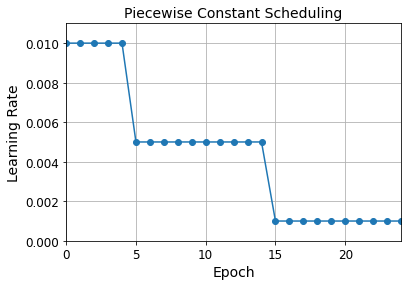

In [26]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

Measure the validation error every N steps (just like for early stopping) and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

For performance scheduling, simply use the ReduceLROnPlateau callback. For example, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for 5 consecutive epochs (other options are available, please check the documentation for more details):

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7116 - accuracy: 0.7769 - val_loss: 0.4869 - val_accuracy: 0.8478
Epoch 2/25
1719/1719 [==============================] - 2s 947us/step - loss: 0.4912 - accuracy: 0.8390 - val_loss: 0.5958 - val_accuracy: 0.8270
Epoch 3/25
1719/1719 [==============================] - 2s 987us/step - loss: 0.5222 - accuracy: 0.8379 - val_loss: 0.4869 - val_accuracy: 0.8584
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5061 - accuracy: 0.8467 - val_loss: 0.4588 - val_accuracy: 0.8548
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5216 - accuracy: 0.8469 - val_loss: 0.6096 - val_accuracy: 0.8300
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4984 - accuracy: 0.8546 - val_loss: 0.5359 - val_accuracy: 0.8498
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5104 - accuracy: 0.8579 - val_loss: 0.5457 - val_accur

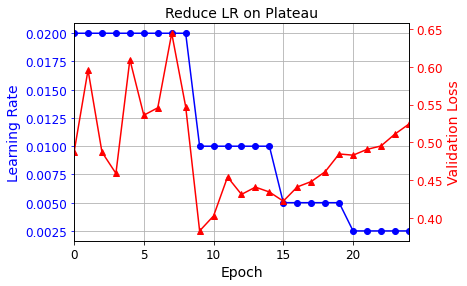

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

A 2013 paper by Andrew Senior et al. compared the performance of some of the most popular learning schedules when training deep neural networks for speech recognition using Momentum optimization. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well. They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution (they also mentioned that it was easier to implement than performance scheduling, but in Keras both options are easy).

### tf.keras schedulers

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: just define the learning rate using one of the schedules available in keras.optimiz then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as earlier:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5995 - accuracy: 0.7923 - val_loss: 0.4095 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3890 - accuracy: 0.8613 - val_loss: 0.3738 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3530 - accuracy: 0.8772 - val_loss: 0.3735 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3296 - accuracy: 0.8813 - val_loss: 0.3494 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3178 - accuracy: 0.8867 - val_loss: 0.3430 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2930 - accuracy: 0.8951 - val_loss: 0.3414 - val_accuracy: 0.8826
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2854 - accuracy: 0.8985 - val_loss: 0.3354 - val_accuracy:

For piecewise constant scheduling, try this:

In [28]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

# Avoiding Overfitting Through Regularization

Deep neural networks typically have tens of thousands of parameters, sometimes even millions. With so many parameters, the network has an incredible amount of freedom and can fit a huge variety of complex datasets. But this great flexibility also means that it is prone to overfitting the training set. We need regularization.

## Batch Normalization

We already implemented one of the best regularization techniques called Batch Normalization. Even though Batch Normalization was designed to solve the vanishing/exploding gradients problems, is also acts like a pretty good regularizer.

## $\ell_1$ and $\ell_2$ regularization

For simple linear models, you can use $\ell_1$ and $\ell_2$ regularization to constrain a neural network’s connection weights (but typically not its biases). Here is how to apply $\ell_2$ regularization to a Keras layer’s connection weights, using a regularization factor of 0.01:

In [29]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

You will typically want to apply the same regularizer to all layers in your net‐ work, as well as the same activation function and the same initialization strategy in all hidden layers.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.2189 - accuracy: 0.7967 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7280 - accuracy: 0.8247 - val_loss: 0.6850 - val_accuracy: 0.8376


You may find yourself repeating the same arguments over and over. This makes it ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s functools.partial() function: it lets you create a thin wrapper for any callable, with some default argument values. For example:

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.2911 - accuracy: 0.7924 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7282 - accuracy: 0.8245 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

Dropout is one of the most popular regularization techniques for deep neural networks. It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter p is called the dropout rate, and it is typically set to 50%.

After training, neurons don’t get dropped anymore. There is one small but important technical detail. Suppose p = 50%, in which case during testing a neuron will be connected to twice as many input neurons as it was (on average) during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/dropout.png" width="70%"/>

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5699 - accuracy: 0.8038 - val_loss: 0.3663 - val_accuracy: 0.8648
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4227 - accuracy: 0.8446 - val_loss: 0.3417 - val_accuracy: 0.8718


## Alpha Dropout

If you want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), you should use **AlphaDropout**: this is a variant of dropout that preserves the mean and standard deviation of its inputs (it was introduced in the same paper as SELU, as regular dropout would break self-normalization).


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8023 - accuracy: 0.7146 - val_loss: 0.5781 - val_accuracy: 0.8442
Epoch 2/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5663 - accuracy: 0.7905 - val_loss: 0.5182 - val_accuracy: 0.8520
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5264 - accuracy: 0.8054 - val_loss: 0.4874 - val_accuracy: 0.8600
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5126 - accuracy: 0.8092 - val_loss: 0.4890 - val_accuracy: 0.8598
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5071 - accuracy: 0.8133 - val_loss: 0.4266 - val_accuracy: 0.8696
Epoch 6/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4793 - accuracy: 0.8198 - val_loss: 0.4585 - val_accuracy: 0.8640
Epoch 7/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4724 - accuracy: 0.8262 - val_loss: 0.4740 - val_accuracy:

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 834us/step - loss: 0.4723 - accuracy: 0.8639


[0.47229740023612976, 0.8639000058174133]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 782us/step - loss: 0.3501 - accuracy: 0.8840


[0.3501231074333191, 0.8840363621711731]

In [ ]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.4225 - accuracy: 0.8432


# Summary and Practical Guidelines

- The configuration in Table below will work fine in most cases, without requiring much hyperparameter tuning.

|Hyperparameter|Default value| 
|-----|-------| 
|Kernel initializer|LeCun initialization| 
|Activation function|SELU|
|Normalization|None (self-normalization)|
|Regularization|Early stopping|
|Optimizer|Nadam|
|Learning rate schedule|Performance scheduling|

- Don’t forget to standardize the input features
- Take advantage of pre-trained models if if you can find one that solves a similar problem (transfer learning)
- The default configuration (Table) may need to be tweaked:
  - If your model self-normalizes and it overfits: then you should add alpha dropout (and always use early stopping as well). Do not use other regularization methods, or else they would break self-normalization.
  - If your model cannot self-normalize (e.g., it is a recurrent net or it contains skip connections): 
    - You can try using ELU (or another activation function) instead of SELU, it may perform better. Make sure to change the initialization method accord‐ ingly (e.g., He init for ELU or ReLU).
    - If it is a deep network, you should use Batch Normalization after every hidden layer. If it overfits the training set, you can also try using max-norm or L2 regularization.
  - If you need a low-latency model (one that performs lightning-fast predictions), you may need to use less layers, avoid Batch Normalization, and possibly replace the SELU activation function with the leaky ReLU. Having a sparse model will also help. You may also want to reduce the float precision from 32-bits to 16-bit (or even 8-bits)



 

